In [1]:
import numpy as np
import math as mp
import pandas as pd

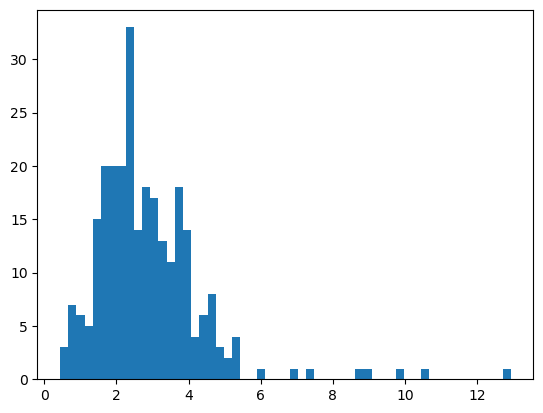

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_24970/1959530809.py:13: RuntimeWarning: divide by zero encountered in log
  N = -(data_tau) - 1/np.log(beta*c)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_24970/1959530809.py:14: RuntimeWarning: divide by zero encountered in log
  tau1= -1/np.log(beta*c) - N
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_24970/1959530809.py:16: RuntimeWarning: divide by zero encountered in log
  tau2= -1/np.log(beta1*c) - N


In [2]:
sigma = 5
beta = 1 /( 1.0 +0.01)
beta1 =1/( (1.0 +0.01* np.exp(30/(36.5*0.9)))) 
W = 1
data=pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau=(data['invtCogsRatio']* 36.5/(30*0.1))
import matplotlib.pyplot as plt
plt.hist(data_tau,bins = 55)
plt.show()
tau_diff = np.zeros(( 1000,1))
i = 0
for c in np.linspace(0, 0.99, 1000): 
    N = -(data_tau) - 1/np.log(beta*c) 
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0     
    tau2= -1/np.log(beta1*c) - N
    tau2[tau2<0] = 0    
    tau_diff[i] = np.mean(np.abs(tau1-tau2))
    i = i+1

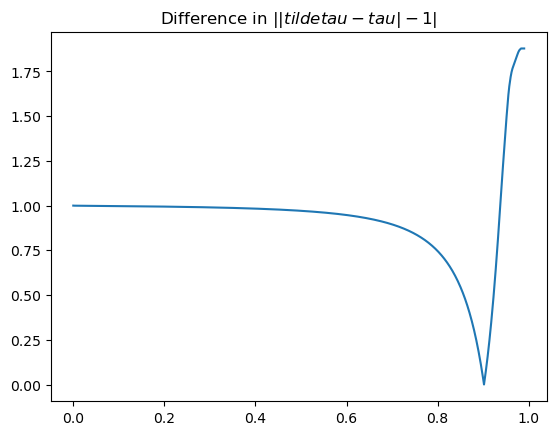

In [3]:
plt.plot(np.linspace(0, 0.99, 1000),np.abs(tau_diff-1))
plt.title('Difference in $||tildetau - tau| -1|$')

plt.show()

In [4]:
min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]

In [5]:
c_list = np.linspace(0, 0.99, 1000)
c=c_list[argmins]

In [6]:
N=-data_tau - 1/np.log(beta*c) 
tau= -1/np.log(beta*c) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  (beta*c)**tau_ceil * (tau_ceil + N)
tprod_floor=  (beta*c)**tau_floor * (tau_floor + N)

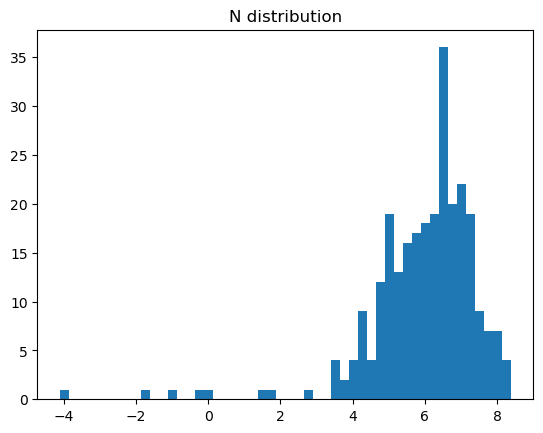

In [7]:
plt.hist(N, bins=50)
plt.title('N distribution')
plt.show()

In [8]:
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0  
tprod = (beta*c)**tau * (tau + N)
tau = np.array(tau, dtype=int)

In [9]:
r = 0.1
beta_org = (1 / (1 + 0.01))*c
tau= -1/np.log(beta_org) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  beta_org**tau_ceil * (tau_ceil + N)
tprod_floor=  beta_org**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0 
tprod1=  np.array(beta_org**tau * (tau + N) )  
P0 = (np.sum(1/(tprod1)**(1-sigma)))**(1/(1-sigma)) 

beta_rep = (1 / (1 + r))*c
tau_rep= -1/np.log(beta_rep) - N
tau_rep[tau_rep<0] = 0  
tau_rep_floor = np.floor(tau_rep)
tau_rep_ceil = np.ceil(tau_rep)
tprod_ceil=  beta_rep**tau_rep_ceil * (tau_rep_ceil + N)
tprod_floor=  beta_rep**tau_rep_floor * (tau_rep_floor + N)
tau_rep[(tprod_ceil-tprod_floor)>0] = tau_rep_ceil[(tprod_ceil-tprod_floor)>0]
tau_rep[(tprod_ceil-tprod_floor)<0] = tau_rep_floor[(tprod_ceil-tprod_floor)<0]
tau_rep[tau_rep<0] = 0 
tprod_rep=  np.array(beta_rep**tau_rep * (tau_rep + N) )  
P1 = (np.sum(1/(tprod_rep)**(1-sigma)))**(1/(1-sigma)) 

P = np.zeros((int(np.max(tau_rep))+2, 1))
P[0, 0] = P0
P[-1, 0] = P1


tau = tau.sort_values()
tau_rep = tau_rep.sort_values()
diff = tau-tau_rep
index_diff=tau_rep[diff !=0].index

In [10]:
tau_list = {}
tau_list[0] = np.array(tau)

for j in range(0, int(np.max(tau_rep)) + 1):
    tau1_temp = pd.Series(tau[tau > j])
    tau2_temp = pd.Series(tau_rep[tau_rep <= j])

    tau1_temp_df = tau1_temp.to_frame(name='t')
    tau1_temp_df['source'] = 'org'

    tau2_temp_df = tau2_temp.to_frame(name='t')
    tau2_temp_df['source'] = 'rep'

    t_temp = pd.concat([tau1_temp_df, tau2_temp_df])

    dup_indices = t_temp.index[t_temp.index.duplicated(keep=False)].unique()

    keep_rows = []

    for i in dup_indices:
        rows = t_temp.loc[[i]]
        N_temp = N.loc[[i]]
        t_org = rows[rows['source'] == 'org']['t'].values[0]
        t_rep = rows[rows['source'] == 'rep']['t'].values[0]

        tprod_org_temp = beta_org**t_org * (t_org + N_temp)
        tprod_rep_temp = beta_rep**t_rep * (t_rep + N_temp)

        # Keep only the row with the higher value
        if tprod_org_temp.values >= tprod_rep_temp.values:
            keep_rows.append(rows[rows['source'] == 'org'])
        else:
            keep_rows.append(rows[rows['source'] == 'rep'])

    # Drop all duplicates first
    t_temp = t_temp[~t_temp.index.isin(dup_indices)]

    # Add back only the best ones
    if keep_rows:
        t_temp = pd.concat([t_temp] + keep_rows)
    t_temp['N'] = N.loc[t_temp.index].values

    # Step 1: Add matching N values
    t_temp['N'] = N.loc[t_temp.index].values  # will align correctly by NAICS6 index

    # Step 2: Compute t_prod using vectorized logic
    beta_vec = t_temp['source'].map({'org': beta_org, 'rep': beta_rep})

    t_temp['t_prod'] = beta_vec ** t_temp['t'] * (t_temp['t'] + t_temp['N'])

    
    tprod_temp = t_temp['t_prod'].values



# Compute P[j+1, 0]
    P[j + 1, 0] = (np.sum(1 / (tprod_temp ** (1 - sigma)))) ** (1 / (1 - sigma))




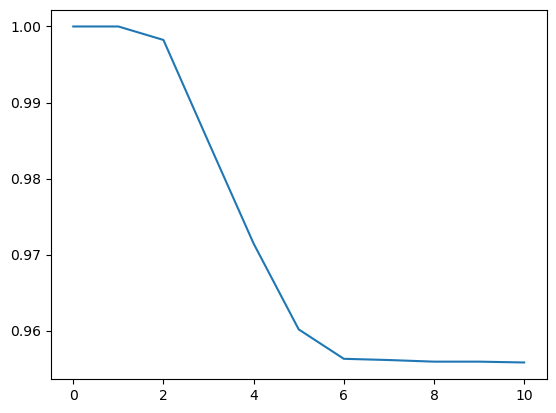

In [11]:
plt.plot( 1/ P *  P[0,0])
plt.show()